In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

MessageError: ignored

In [ ]:
from google import colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/FYP

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/FYP


#**Downloading pre-trained fastText, preparing datasets, and pre-processing**

In [ ]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Converting all the words to index in number, to the embedding index in pre-trained model and converted all the missing words to 0,

In [ ]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


1999996it [03:41, 9049.59it/s] 

found 1999996 word vectors


Read both the train data and test data

In [ ]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('cyberbullying_tweets_new.csv', sep=',')
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("test_dat.csv")
train_data.to_csv("train_dat.csv")

train_df = pd.read_csv('train_dat.csv', sep=',', header=0)
test_df = pd.read_csv('test_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  57473
Number of testing data:  14369


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


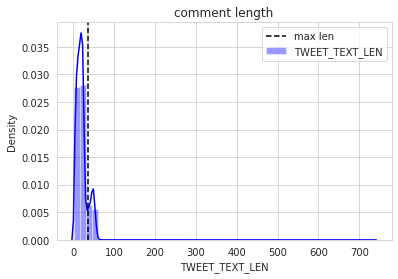

In [ ]:
label_names = ["RESULT"]
y_train = train_df[label_names].values
train_df['TWEET_TEXT_LEN'] = train_df['TWEET_TEXT'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['TWEET_TEXT_LEN'].mean() + train_df['TWEET_TEXT_LEN'].std()).astype(int)

sns.distplot(train_df['TWEET_TEXT_LEN'], hist=True, kde=True, color='b', label='TWEET_TEXT_LEN')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

tokenizing the data with tokenizer from tensorflow

In [ ]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['TWEET_TEXT'].tolist()
raw_docs_test = test_df['TWEET_TEXT'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 14369/14369 [00:03<00:00, 3611.66it/s]


tokenizing input data...
dictionary size:  68564


#**Shape and Train with LSTM**

defining variables that used on training

In [ ]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

building the embedding matrix for the weights in Embedding Layer on training. more about embedding matrix: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

all words that aren't in the pre-trained model from fasttext would be changed to 0. the words are basically the ones with typos or names, the words mostly dont matter so much to the pattern. so it's nicer to just weights it 0.

In [ ]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 30539


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['jagregory' 'healthcareisforyouandmenotforfuckingindustry' 'winj8awbla'
 'rajdeepsardesai' 'sexmoneybagz' 'cvhaffbfaq' 'geingob' 'kuhnbeardskurse'
 'maggiesmithh' 'wakooz']


let's start training! here are the layers. i have been doing some test and modification on using the layer, unit cells, etc. and so far it works the best for me. tell me i

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           20569500  
                                                                 
 bidirectional (Bidirectiona  (None, 64)               85248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,656,861
Trainable params: 87,361
Non-trainable params: 20,569,500
_______________________________________

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
158/158 [==============================] - 13s 32ms/step - loss: 0.4273 - accuracy: 0.7941 - val_loss: 0.3537 - val_accuracy: 0.8392
Epoch 2/40
158/158 [==============================] - 4s 24ms/step - loss: 0.3492 - accuracy: 0.8412 - val_loss: 0.3383 - val_accuracy: 0.8446
Epoch 3/40
158/158 [==============================] - 4s 24ms/step - loss: 0.3280 - accuracy: 0.8494 - val_loss: 0.3367 - val_accuracy: 0.8461
Epoch 4/40
158/158 [==============================] - 4s 24ms/step - loss: 0.3146 - accuracy: 0.8567 - val_loss: 0.3308 - val_accuracy: 0.8491
Epoch 5/40
158/158 [==============================] - 4s 24ms/step - loss: 0.3024 - accuracy: 0.8615 - val_loss: 0.3315 - val_accuracy: 0.8522
Epoch 6/40
158/158 [==============================] - 4s 24ms/step - loss: 0.2915 - accuracy: 0.8655 - val_loss: 0.3328 - val_accuracy: 0.8537
Epoch 7/40
158/158 [==============================] - 4s 24ms/step - loss: 0.2841 - accuracy: 0.8691 - val_loss: 0.3294 - val_accuracy: 0.855

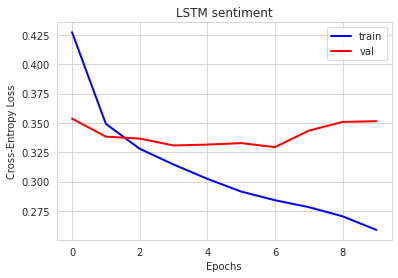

In [ ]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

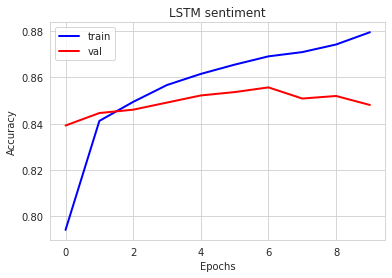

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['TWEET_TEXT']= (predictions>0.5).astype(int)
sample[['TWEET_TEXT', "RESULT"]]

,TWEET_TEXT,RESULT
0,1,1
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
14364,0,0
14365,0,1
14366,0,0
14367,0,0


In [ ]:
import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(sample.RESULT, sample.TWEET_TEXT))

Accuracy With fastText :
0.8483540956225207
